In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [ ]:
# Load Data

data_path = '/content/BaggageComplaints.csv'

bag_dat = pd.read_csv(data_path)

bag_dat.head
bag_dat.info()
print(bag_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    252 non-null    object
 1   Date       252 non-null    object
 2   Month      252 non-null    int64 
 3   Year       252 non-null    int64 
 4   Baggage    252 non-null    int64 
 5   Scheduled  252 non-null    int64 
 6   Cancelled  252 non-null    int64 
 7   Enplaned   252 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.9+ KB
            Airline    Date  Month  Year  Baggage  Scheduled  Cancelled  \
0    American Eagle  Jan-04      1  2004    12502      38276       2481   
1    American Eagle  Feb-04      2  2004     8977      35762        886   
2    American Eagle  Mar-04      3  2004    10289      39445       1346   
3    American Eagle  Apr-04      4  2004     8095      38982        755   
4    American Eagle  May-04      5  2004    10618      40422       2206   
..   

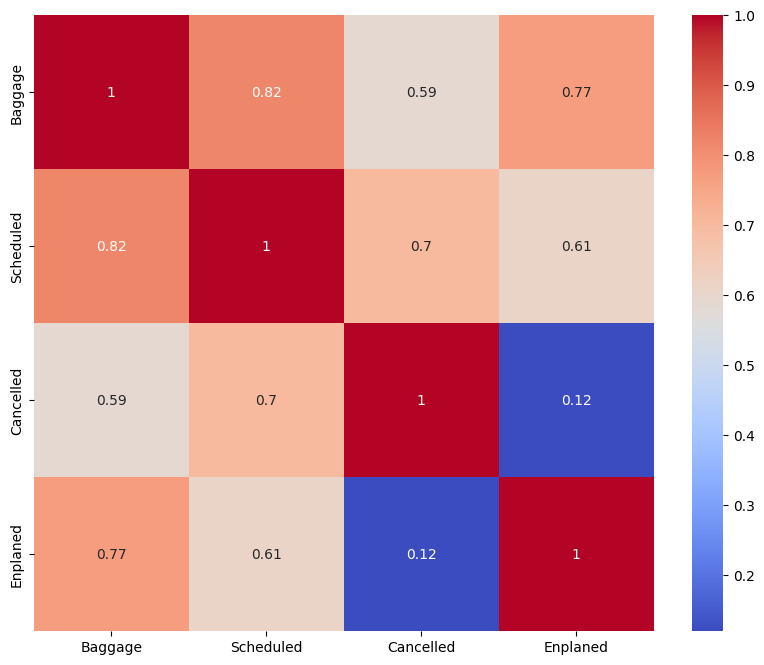

In [ ]:
bag_dat_sub = bag_dat.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat = bag_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

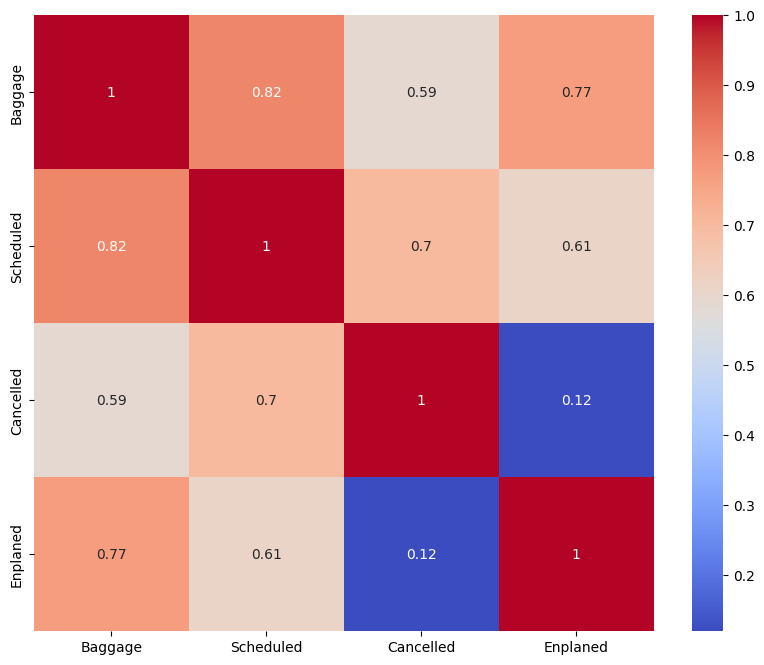

In [359]:
# American Eagle Airlines
american_dat_sub = american_dat.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat = bag_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

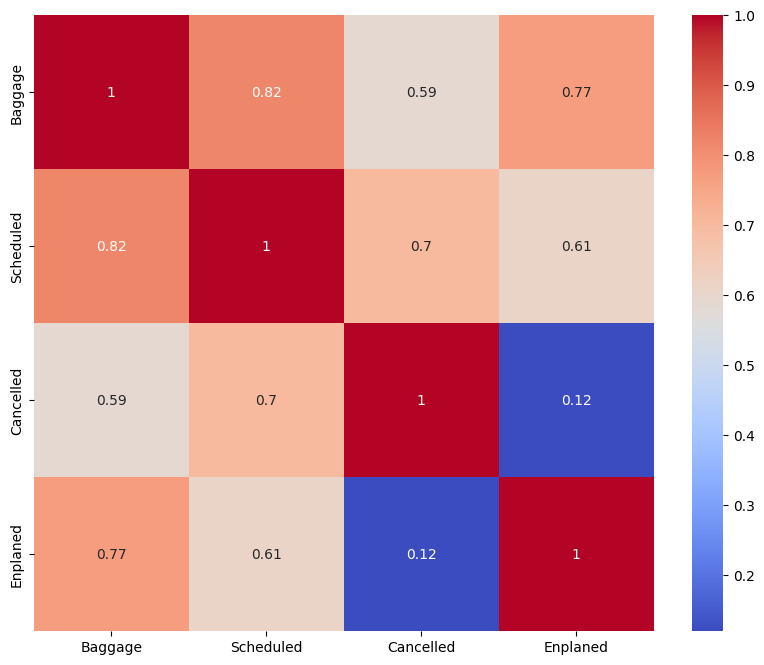

In [360]:
# United Airlines
united_dat_sub = united_dat.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat = bag_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

In [ ]:
bag_dat['Airline'].unique()

array(['American Eagle', 'Hawaiian', 'United'], dtype=object)

In [ ]:
# Filter the data by applying a boolean mask to just get American Eagle data
american = bag_dat['Airline'] == 'American Eagle'
american_dat = bag_dat[american]

In [ ]:
# Filter the data by applying a boolean mask to just get Hawaiian Airlines data
united = bag_dat['Airline'] == 'United'
united_dat = bag_dat[united]

In [ ]:
# Filter the data by applying a boolean mask to just get United Airlines data
hawaiian = bag_dat['Airline'] == 'Hawaiian'
hawaiian_dat = bag_dat[hawaiian]

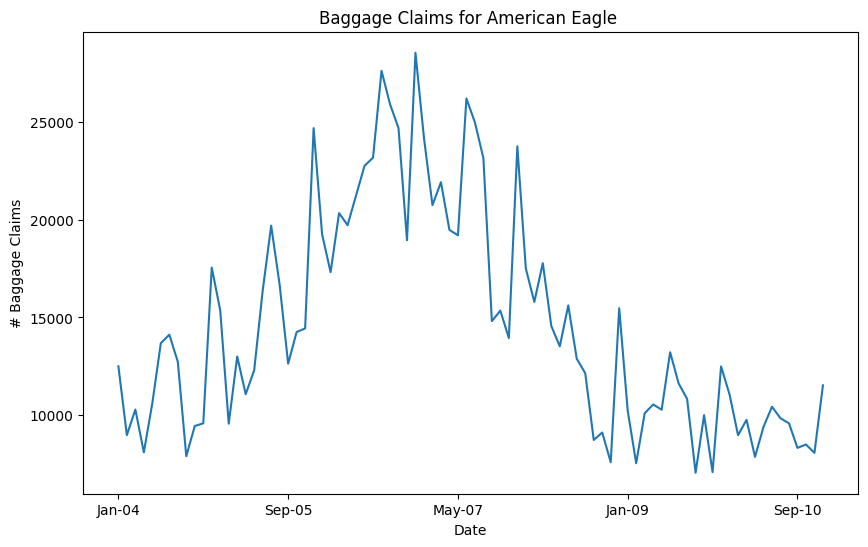

In [395]:
# American Airlines
# Convert date column to a date class variable
american_bag_ts = pd.Series(american_dat['Baggage'].values, index=american_dat['Date'])

# Create a monthly index for the series
american_bag_ts.index.freq = 'MS'

#Plot the series
plt.figure(figsize=(10, 6))
american_bag_ts.plot()
plt.title("Baggage Claims for American Eagle ")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.show()

Time Series Plot for American Eagle suggest taking a single mean difference as all the values are above 0.

In [ ]:
#execute the Ljung Box test on the Coffee series using 10 lags
american_bags = american_dat[['Baggage']]

sm.stats.acorr_ljungbox(american_bags, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,363.970723,4.308185e-72


Series is not white noise. In our ARIMA Model, we would like to have the residual be white noise.

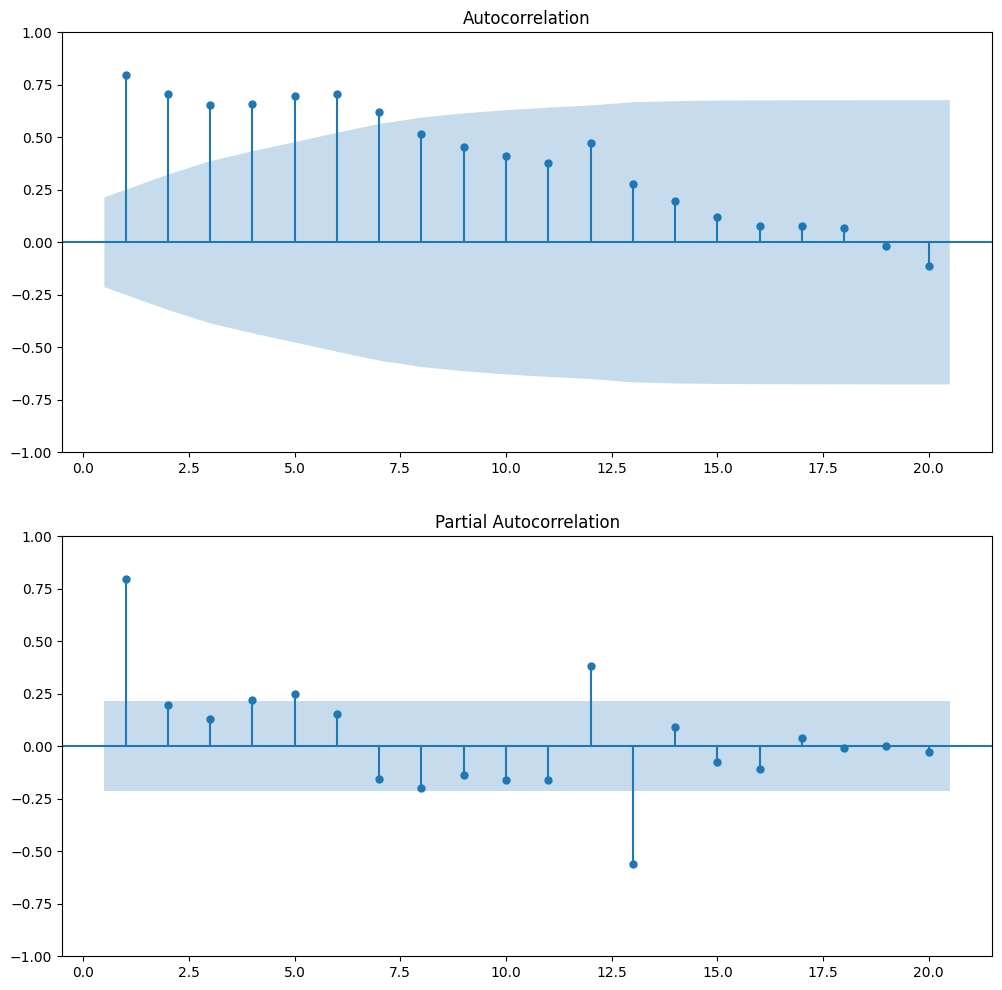

In [ ]:
#Plot the ACF and PACF for the coffee series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(american_bag_ts, ax=ax1, zero=False)
plot_pacf(american_bag_ts, ax=ax2, zero=False)
plt.show()

AR Signature as the ACF slowly decays to 0, while the PACF quickly decays. So, we can determine the amount of P terms by looking at the PACF and see how many residuals go outside the 95% CI band. Here, we think 3 terms would be good if not 2.

## For seasonal time series, the first step in the process is taking a seasonal difference.  To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure.  P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle).  To take a seasonal difference set D=1.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


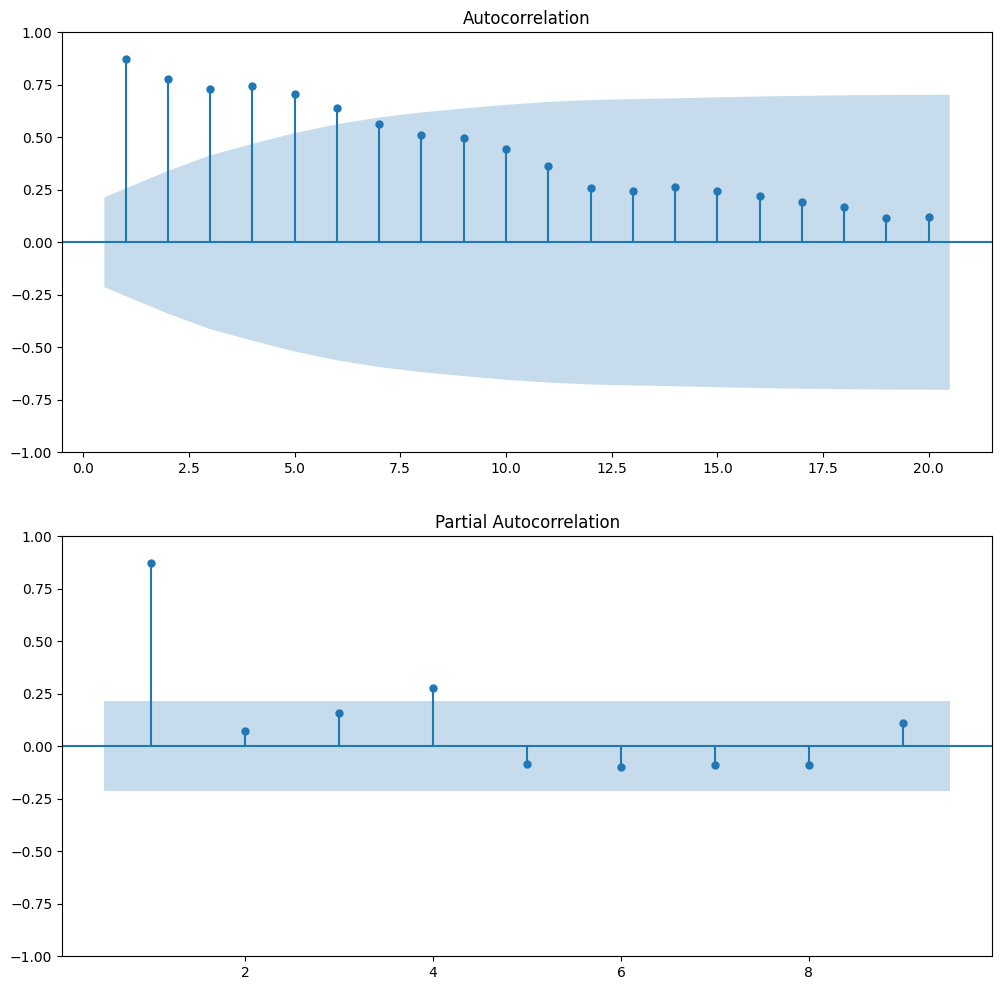

In [ ]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

Notice that the ACF and PACF for the residuals look like a typical autoregressive signature, so the next step might be to add p = 1 to include an AR(1) term in the model.  This will not be sufficient to get the residuals to white noise.  Recall that an MA term can help to smooth out a model after differencing.  In this case we took a seasonal difference, so we'll include a seasonal MA term by setting Q=1 in the seasonal order.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


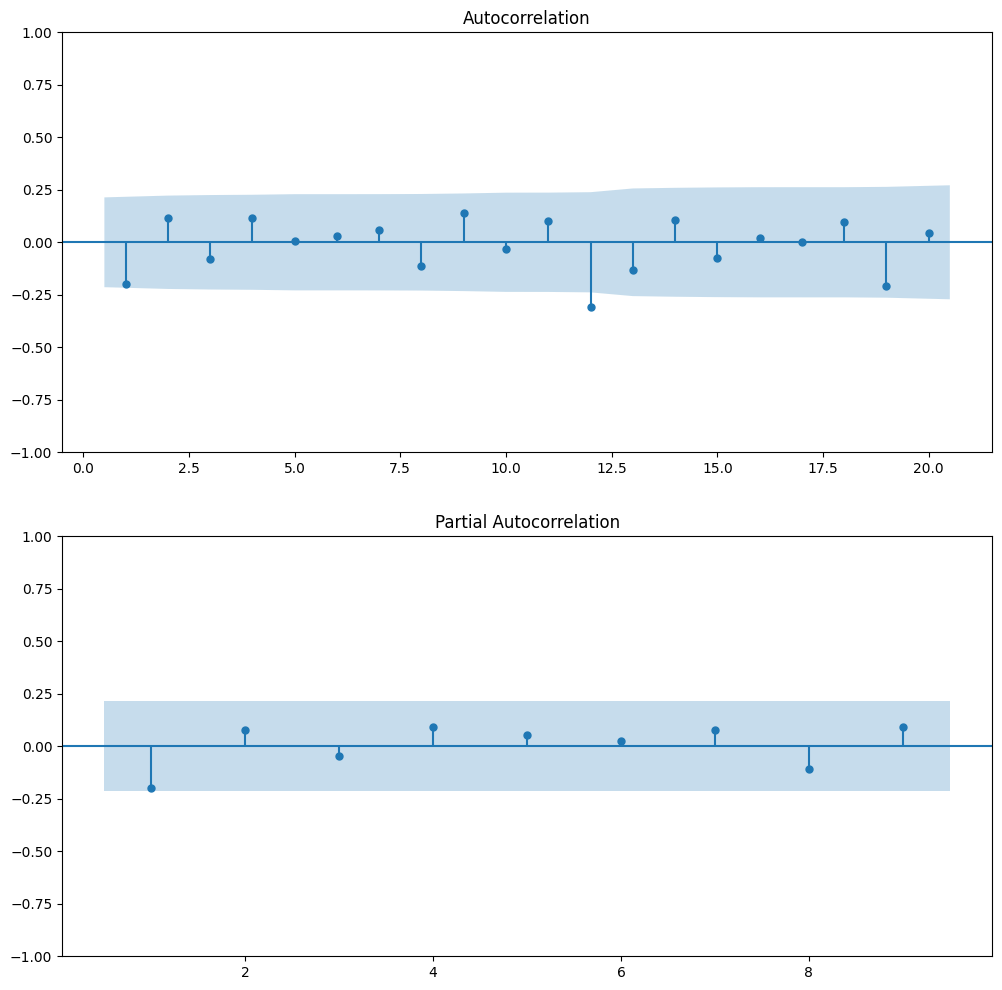

In [ ]:
# Fit ARIMA(3,1,0)x(0,1,0)[12] model to the data - This is simply taking the 24-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_bag_ts, order=(3,1,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

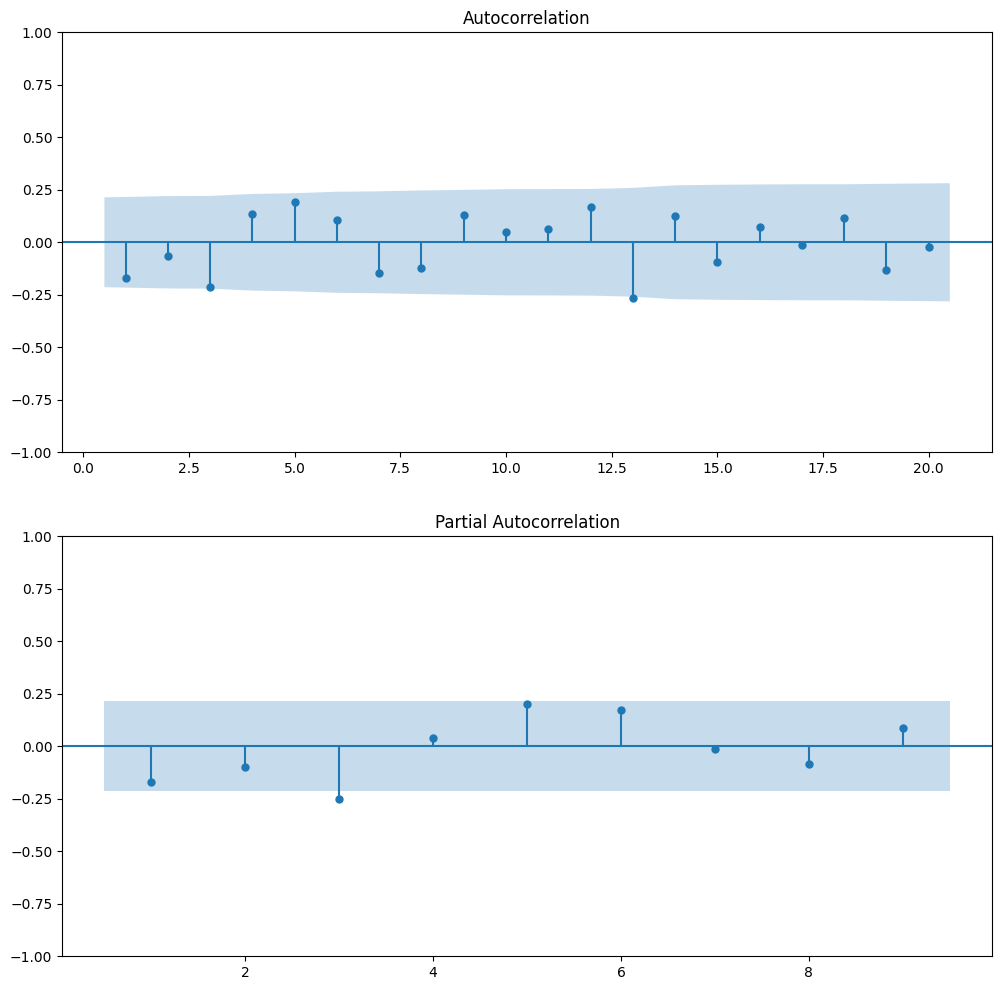

In [377]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 24-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_bag_ts, order=(1,1,1), seasonal_order=(0, 1, 0, 24)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -650.197
Date:                          Sun, 22 Oct 2023   AIC                           1310.393
Time:                                  22:55:36   BIC                           1321.707
Sample:                                       0   HQIC                          1314.892
                                           - 84                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5023      0.417      1.206      0.228      -0.314       1.319
ma.L1         -0.6562      0.372     -1.763      0.

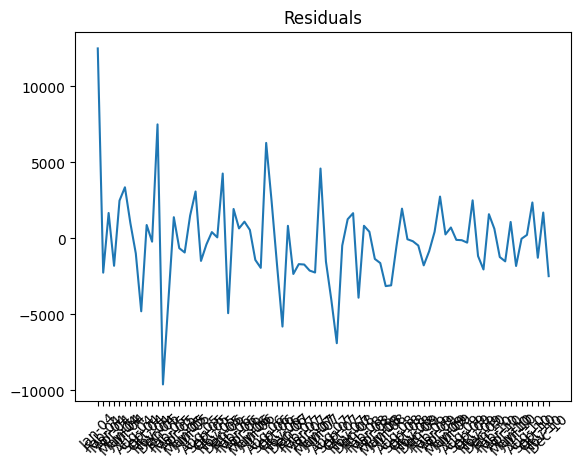

In [394]:
# Fit ARIMA(3,1,0)x(0,1,1)[12] model to the data

#Best model for Baggage Complaints for American is ARIMA(3,1,0)x(0,1,1)[12]
fit_AR1 = ARIMA(american_bag_ts, order=(1,1,1), seasonal_order=(1, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


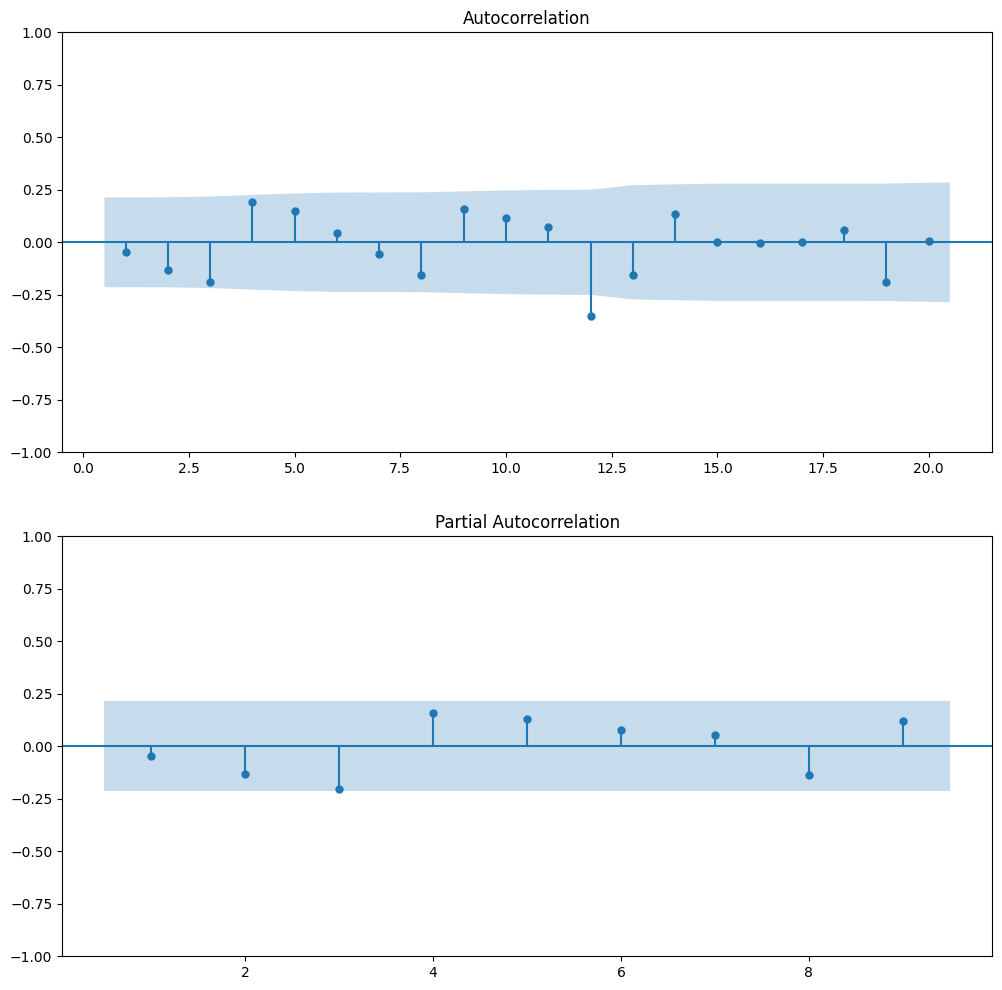

In [389]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()


After reviewing the ACF and PACF for the resiuals from this model and noticing that the Ljung Box test (below) indicates that the residuals are white noise, this seems to be a reasonable model for the data.

In [390]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,16.603368,0.083614


Convert predictions into a data frame in order to compute the forecast error

In [391]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
Feb-04,11362.337144,5906.094753,16818.579534
Mar-04,8533.861060,3094.492098,13973.230021
Apr-04,9814.648055,4384.297026,15244.999085
May-04,8002.204877,2576.714154,13427.695600
Jun-04,10252.201049,4829.341710,15675.060387


Join actual values to predicted values

In [392]:
# add back actuals --
prediction_df = pd.concat([prediction_df,american_bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
Mar-04,8533.861060,3094.492098,13973.230021,10289
Apr-04,9814.648055,4384.297026,15244.999085,8095
May-04,8002.204877,2576.714154,13427.695600,10618
Jun-04,10252.201049,4829.341710,15675.060387,13684
Jul-04,13050.737291,7629.306079,18472.168502,14121


Calculate the Forecast Error

In [393]:
# calc error
errors = prediction_df['Baggage'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Baggage'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 15.536%
RMSE = 2,982.850


Generate the forecast for the next six months

In [385]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecasted_CPI,Lower_Bound,Upper_Bound
84,8835.022257,3796.797479,13873.247035
85,6701.837671,136.812545,13266.862798
86,8175.552732,584.895533,15766.209931
87,6749.236735,-1659.831456,15158.304926
88,7534.847174,-1583.714607,16653.408955
89,9416.413096,-344.390333,19177.216526


Plot the series and append the six month forecast.  Notice that the forecast follows a pattern similar to the one observed in the actual data

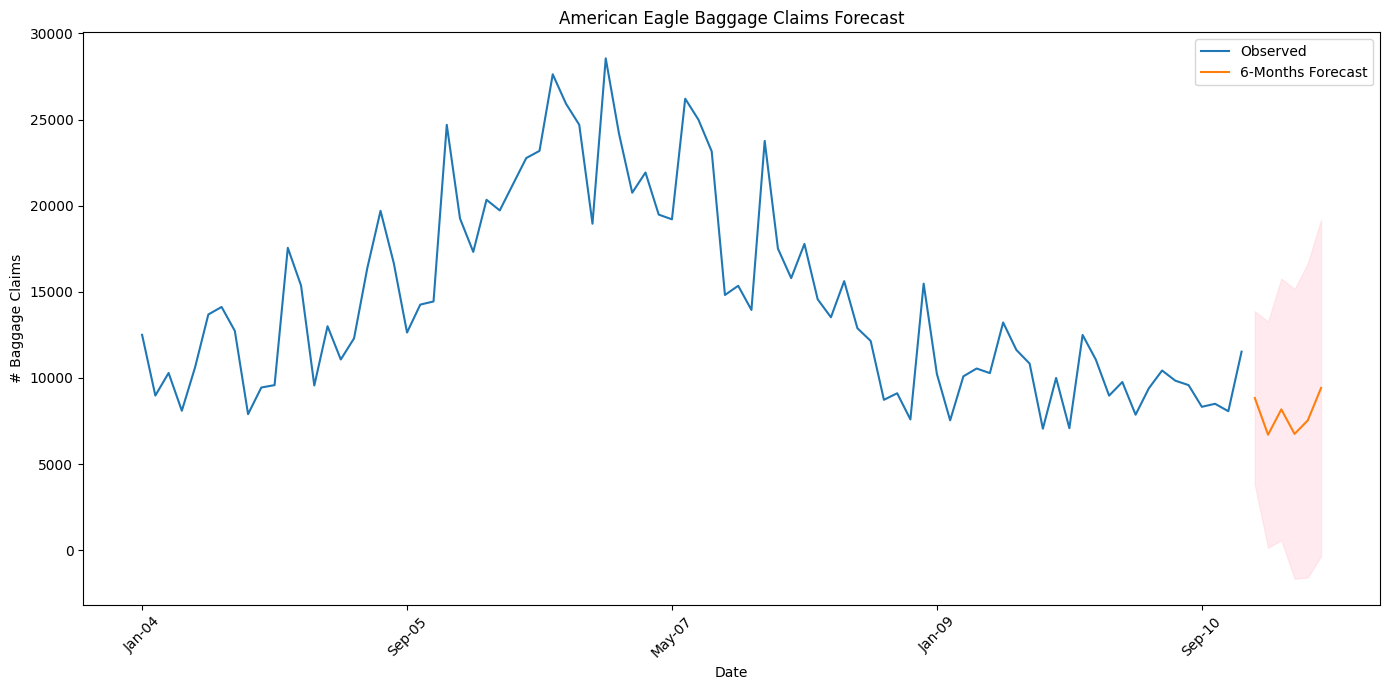

In [397]:

# Plot forecast
plt.figure(figsize=(14, 7))
american_bag_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("American Eagle Baggage Claims Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## Cancelled Flights


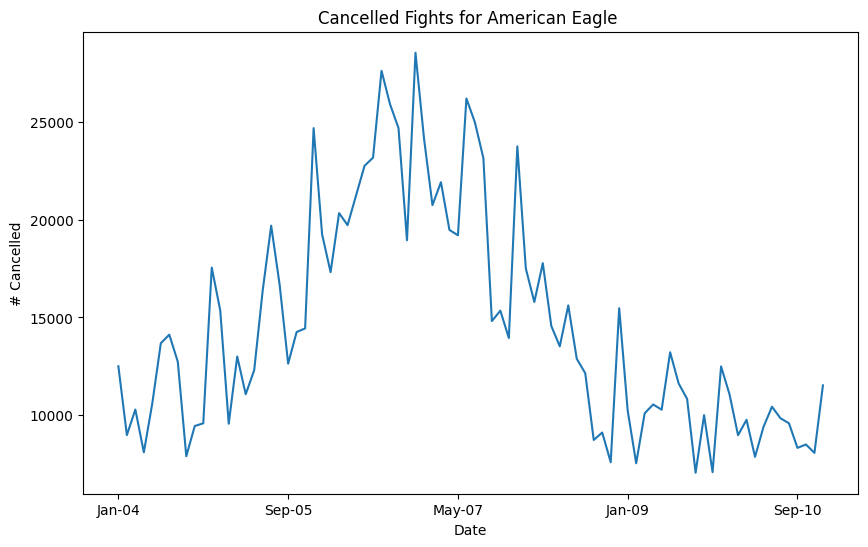

In [401]:
# American Airlines
# Convert date column to a date class variable
american_cancel_ts = pd.Series(american_dat['Cancelled'].values, index=american_dat['Date'])

# Create a monthly index for the series
american_cancel_ts.index.freq = 'MS'

#Plot the series
plt.figure(figsize=(10, 6))
american_bag_ts.plot()
plt.title("Cancelled Fights for American Eagle ")
plt.xlabel("Date")
plt.ylabel("# Cancelled")
plt.show()

In [402]:
#execute the Ljung Box test on the Coffee series using 10 lags
american_cancel = american_dat[['Cancelled']]

sm.stats.acorr_ljungbox(american_cancel, lags=[10], return_df=True)

# Residuals are not white noise

,lb_stat,lb_pvalue
10,33.222572,0.00025


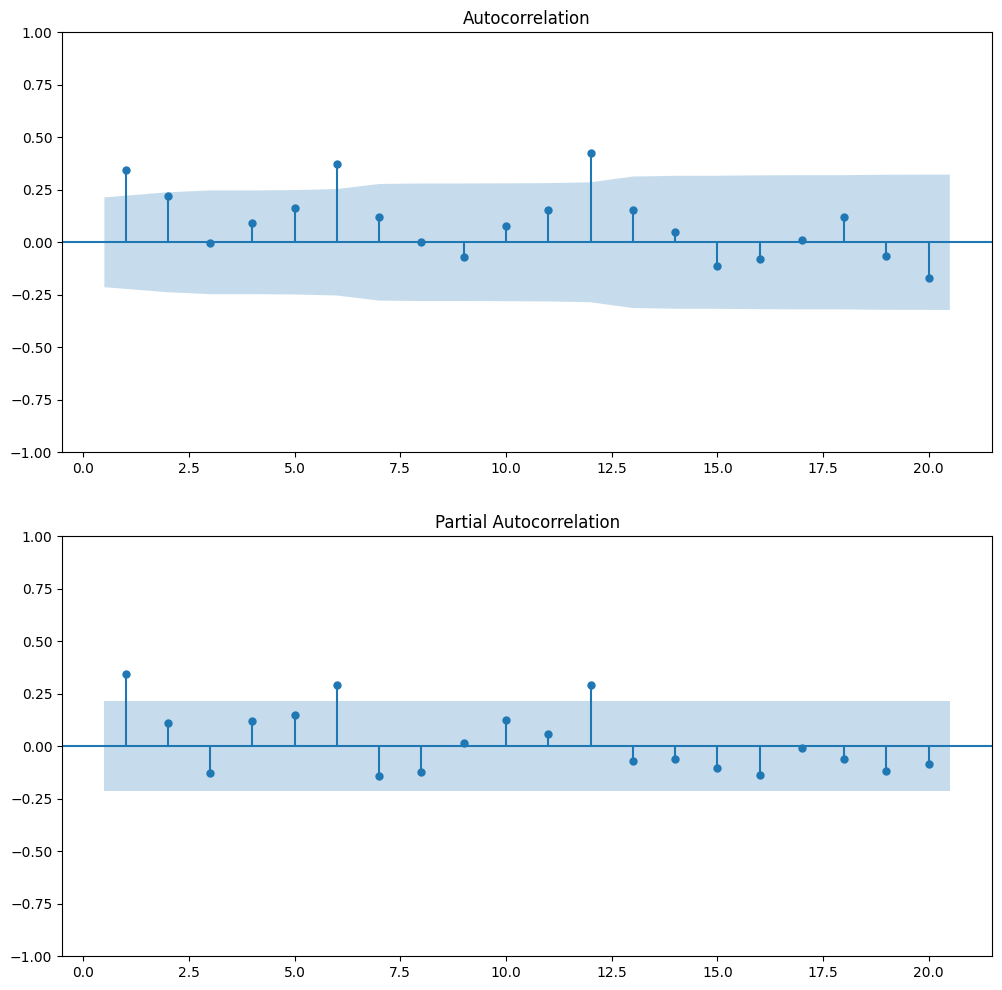

In [403]:
#Plot the ACF and PACF for the cancelled flight series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(american_cancel_ts, ax=ax1, zero=False)
plot_pacf(american_cancel_ts, ax=ax2, zero=False)
plt.show()

# Hard to tell what signature it is so just plug and chug

### For seasonal time series, the first step in the process is taking a seasonal difference. To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure. P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle). To take a seasonal difference set D=1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


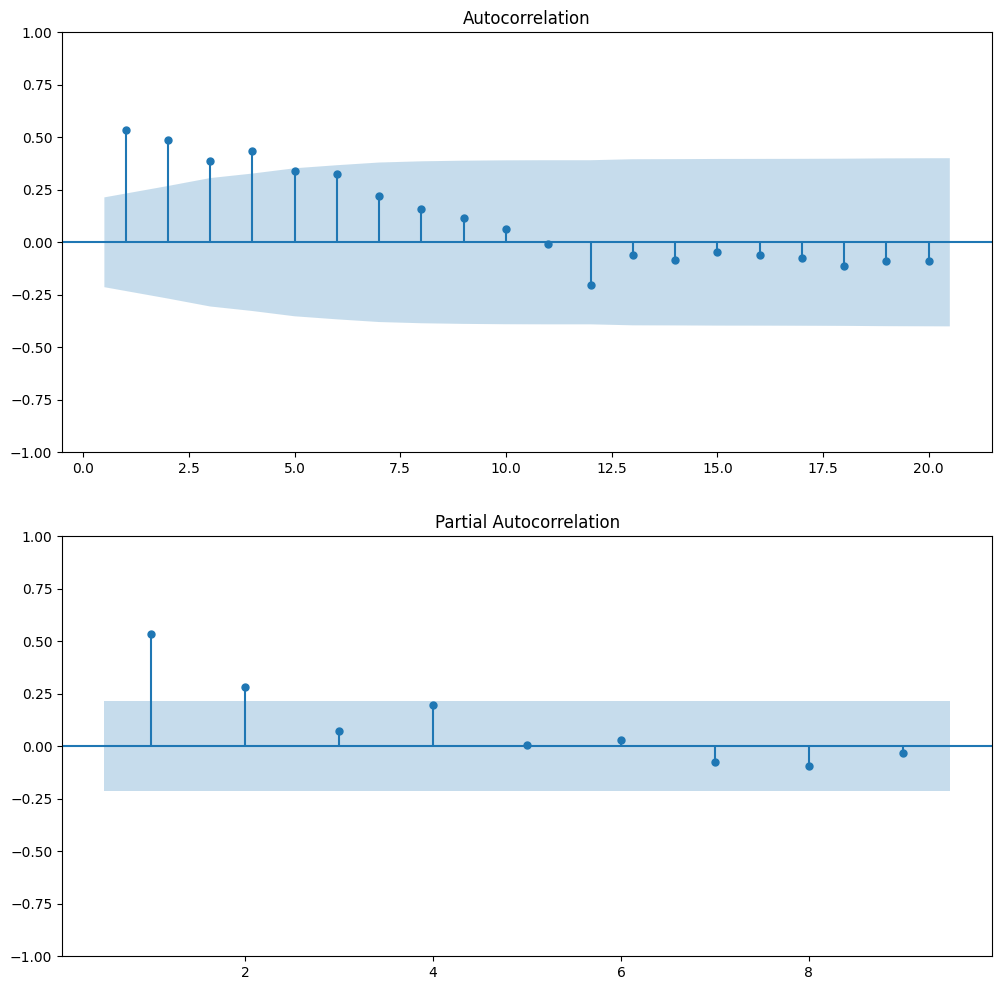

In [404]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_cancel_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


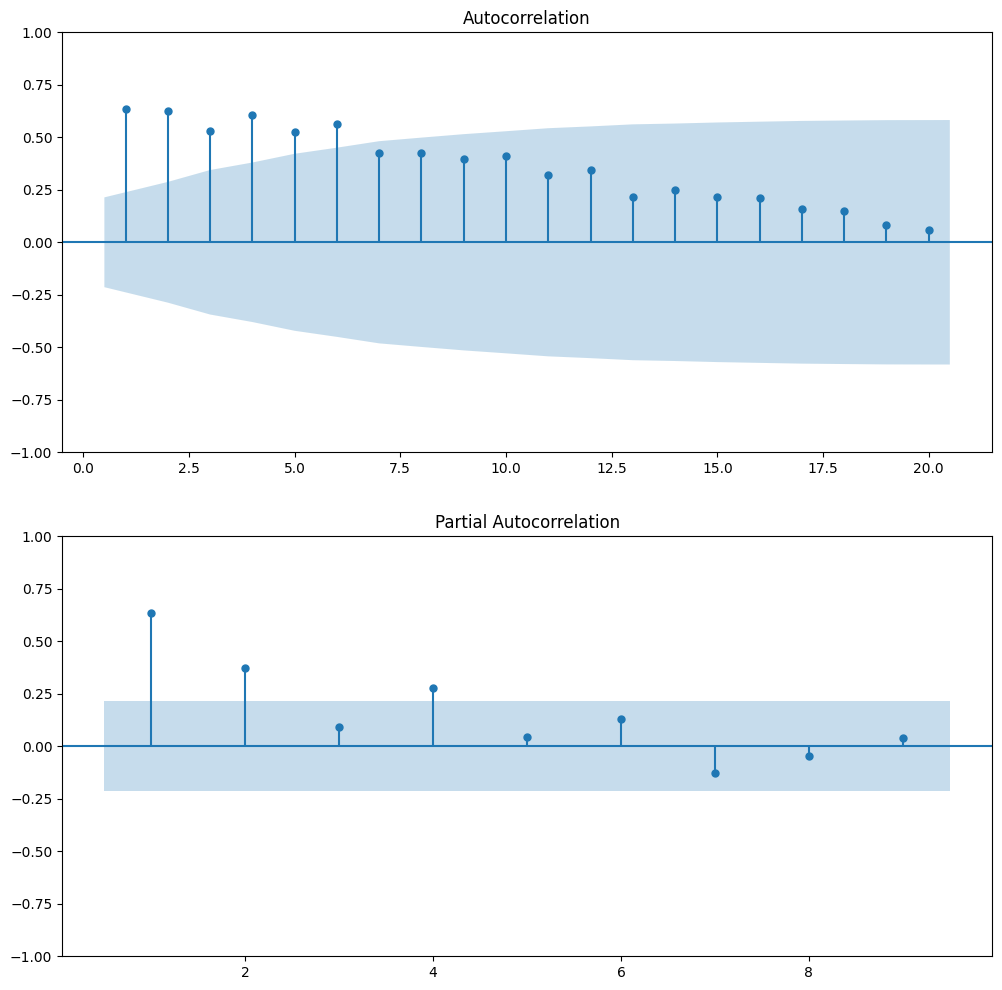

In [405]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 24-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_cancel_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 24)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


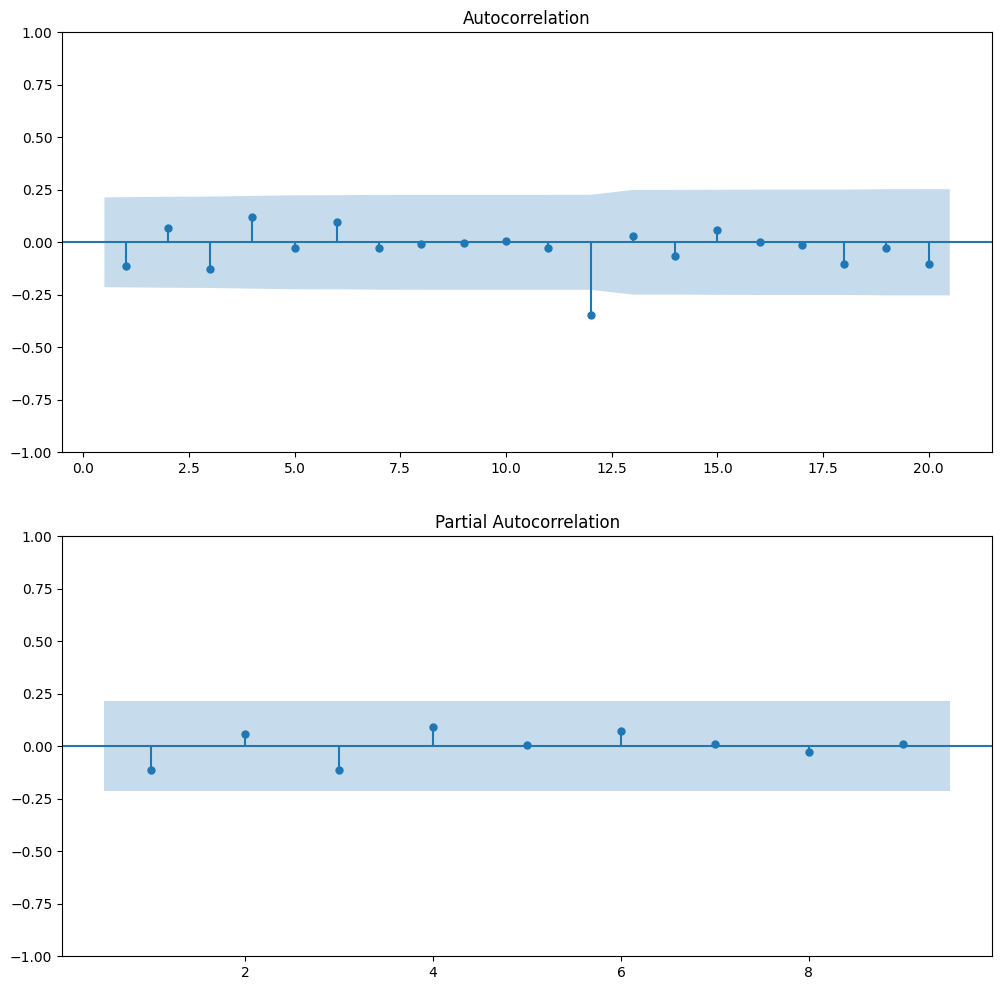

In [406]:
# Fit ARIMA(1,1,1)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_cancel_ts, order=(1,1,1), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

Fit the ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -555.649
Date:                          Sun, 22 Oct 2023   AIC                           1121.298
Time:                                  23:59:05   BIC                           1132.612
Sample:                                       0   HQIC                          1125.797
                                           - 84                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0719      0.184     -0.390      0.696      -0.433       0.289
ma.L1         -0.7043      0.109     -6.479      0.

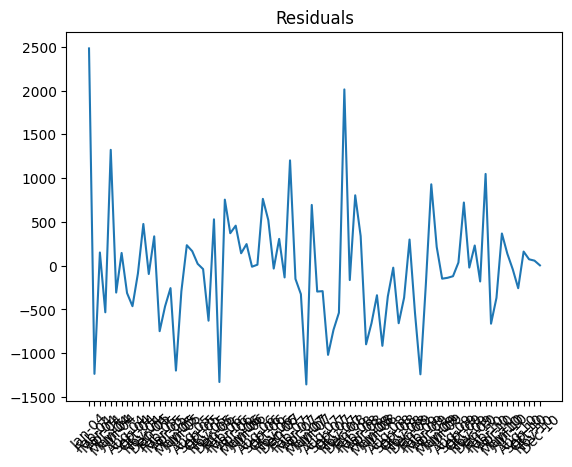

In [407]:
# Fit ARIMA(1,1,0)x(0,1,1)[12] model to the data

#Best model for Baggage Complaints for American is ARIMA(3,1,0)x(0,1,1)[12]
fit_AR1 = ARIMA(american_cancel_ts, order=(1,1,1), seasonal_order=(1, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


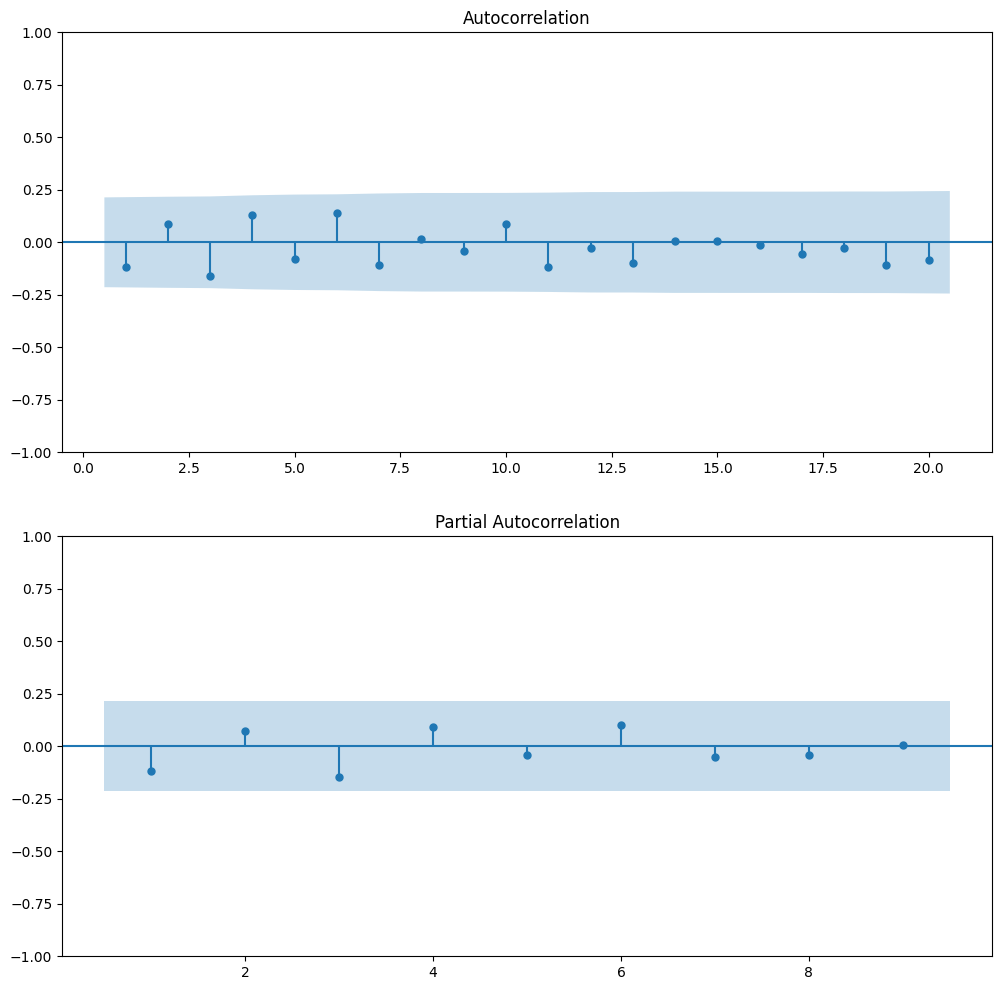

In [408]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()


In [409]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,10.148468,0.427566


In [410]:
# convert predictions to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
Feb-04,2123.164755,-454.343062,4700.672573
Mar-04,1196.355216,-1355.808527,3748.518959
Apr-04,1288.773807,-1262.740444,3840.288058
May-04,883.640689,-1667.856661,3435.138038
Jun-04,1888.250250,-663.246659,4439.747160


In [411]:
# add back actuals --
prediction_df = pd.concat([prediction_df,american_cancel_ts.to_frame(name='Cancelled Flights')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,Cancelled Flights
Date,,,,
Mar-04,1196.355216,-1355.808527,3748.518959,1346
Apr-04,1288.773807,-1262.740444,3840.288058,755
May-04,883.640689,-1667.856661,3435.138038,2206
Jun-04,1888.250250,-663.246659,4439.747160,1580
Jul-04,1674.771787,-876.725111,4226.268685,1819


In [412]:
# calc error
errors = prediction_df['Cancelled Flights'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Cancelled Flights'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 39.597%
RMSE = 592.973


In [413]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecasted_CPI,Lower_Bound,Upper_Bound
84,1486.648252,341.054004,2632.242499
85,1502.860846,328.920787,2676.800905
86,897.877610,-318.956969,2114.712189
87,572.853525,-684.246589,1829.953638
88,777.817934,-518.377570,2074.013439
89,1202.075418,-132.064637,2536.215474


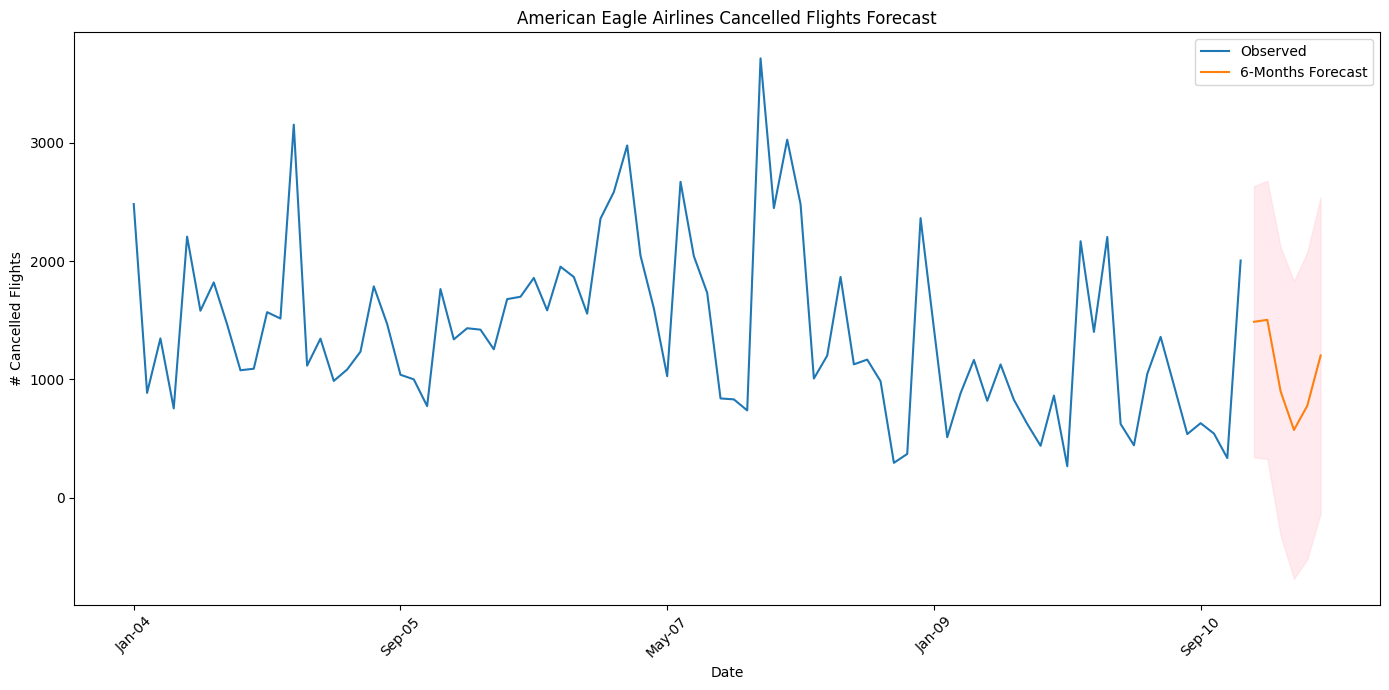

In [415]:

# Plot forecast
plt.figure(figsize=(14, 7))
american_cancel_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("American Eagle Airlines Cancelled Flights Forecast")
plt.xlabel("Date")
plt.ylabel("# Cancelled Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# United Airlines
- Starting with Baggage and then Cancelled Flights Forecasts


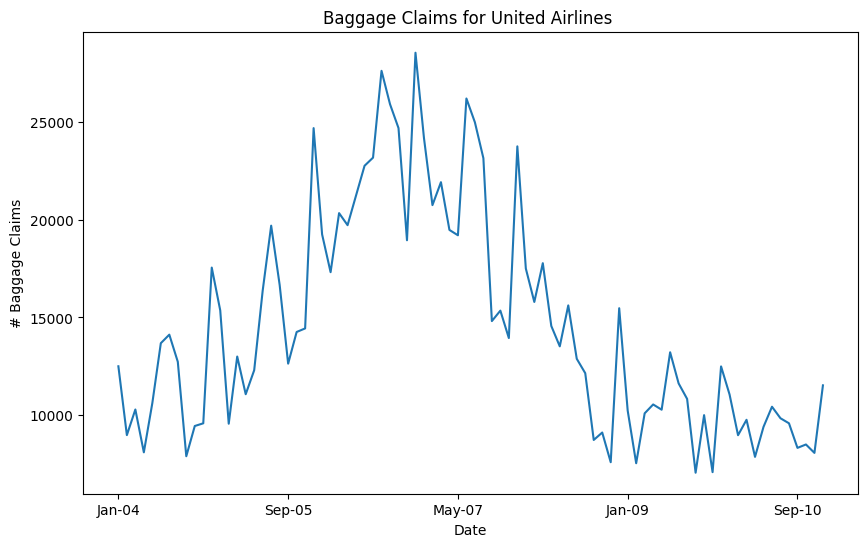

In [416]:
# United Airlines
# Convert date column to a date class variable
united_bag_ts = pd.Series(united_dat['Baggage'].values, index=united_dat['Date'])

# Create a monthly index for the series
united_bag_ts.index.freq = 'MS'

#Plot the series
plt.figure(figsize=(10, 6))
american_bag_ts.plot()
plt.title("Baggage Claims for United Airlines ")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.show()

In [ ]:
#execute the Ljung Box test on the Coffee series using 10 lags
united_bag = united_dat[['Baggage']]

sm.stats.acorr_ljungbox(united_bag, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,160.317171,2.786746e-29


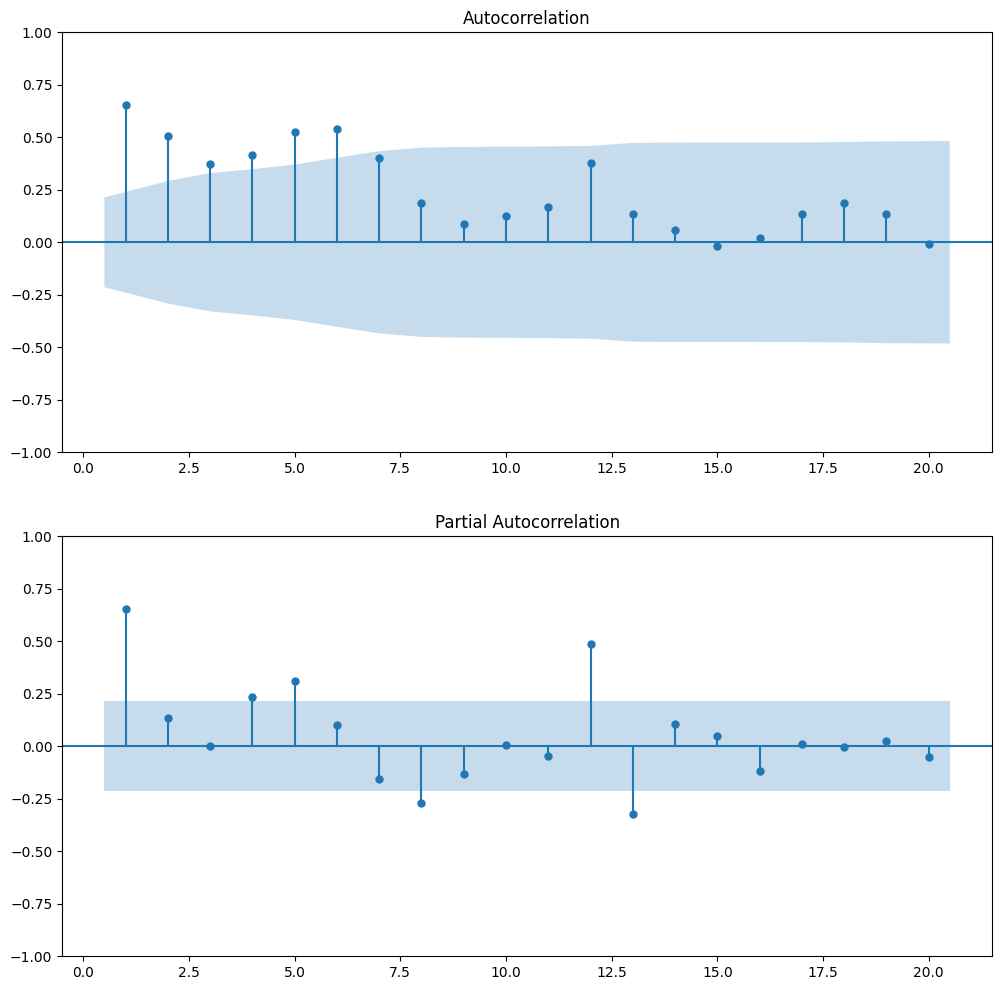

In [ ]:
#Plot the ACF and PACF for the cancelled flight series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(united_bag_ts, ax=ax1, zero=False)
plot_pacf(united_bag_ts, ax=ax2, zero=False)
plt.show()

# Hard to tell what signature it is so just plug and chug

For seasonal time series, the first step in the process is taking a seasonal difference. To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure. P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle). To take a seasonal difference set D=1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


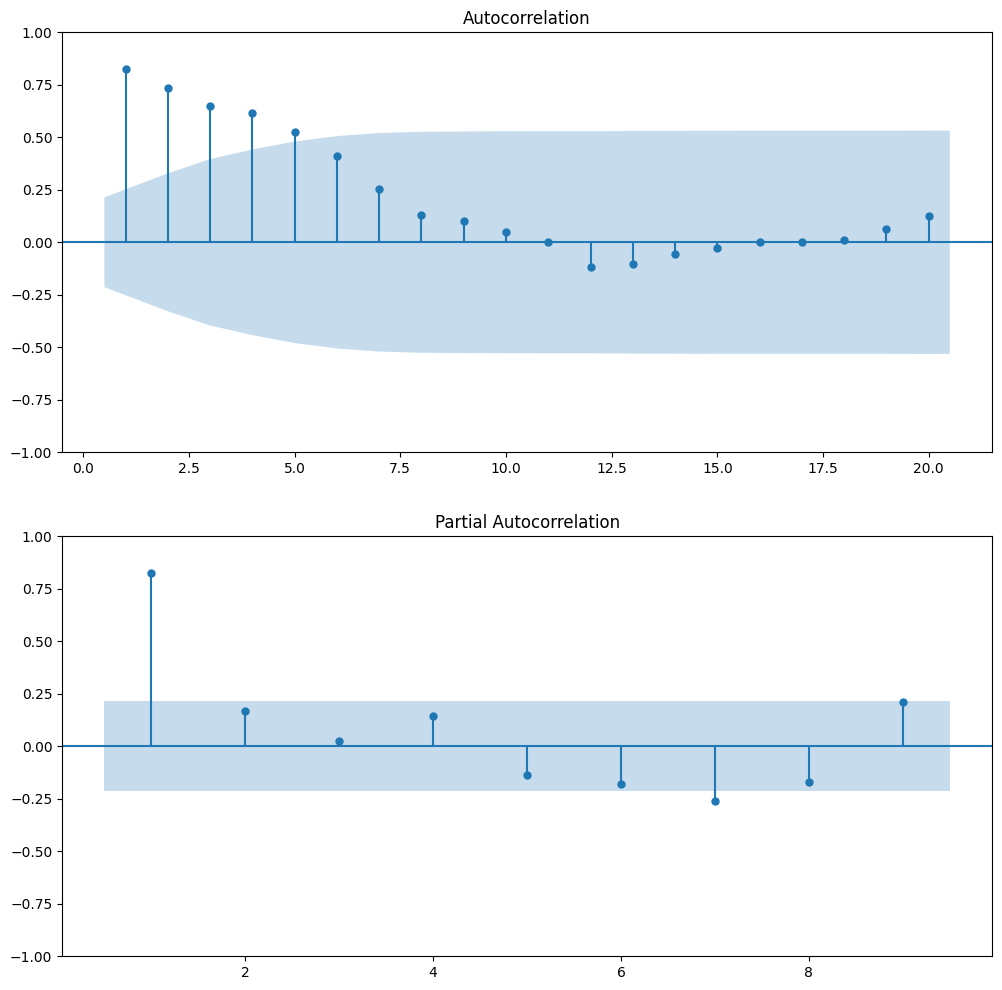

In [ ]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


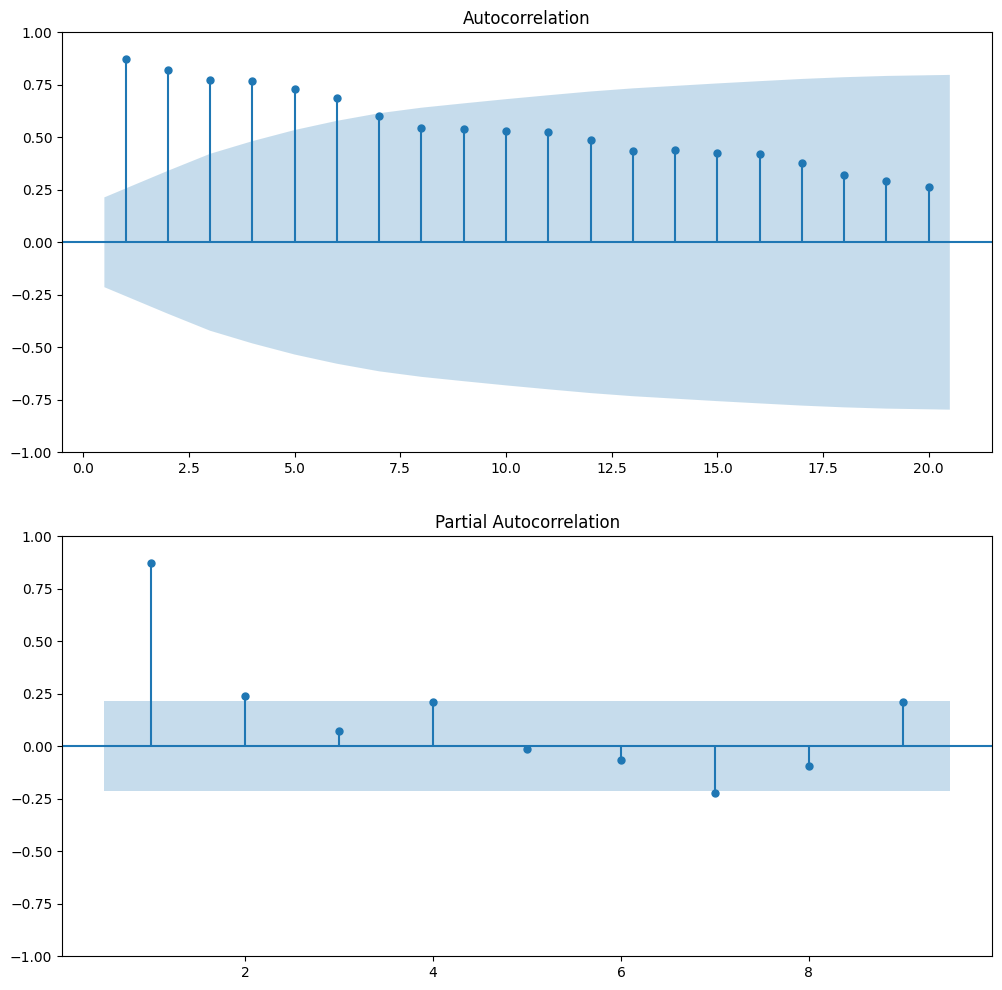

In [ ]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 24-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 24)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


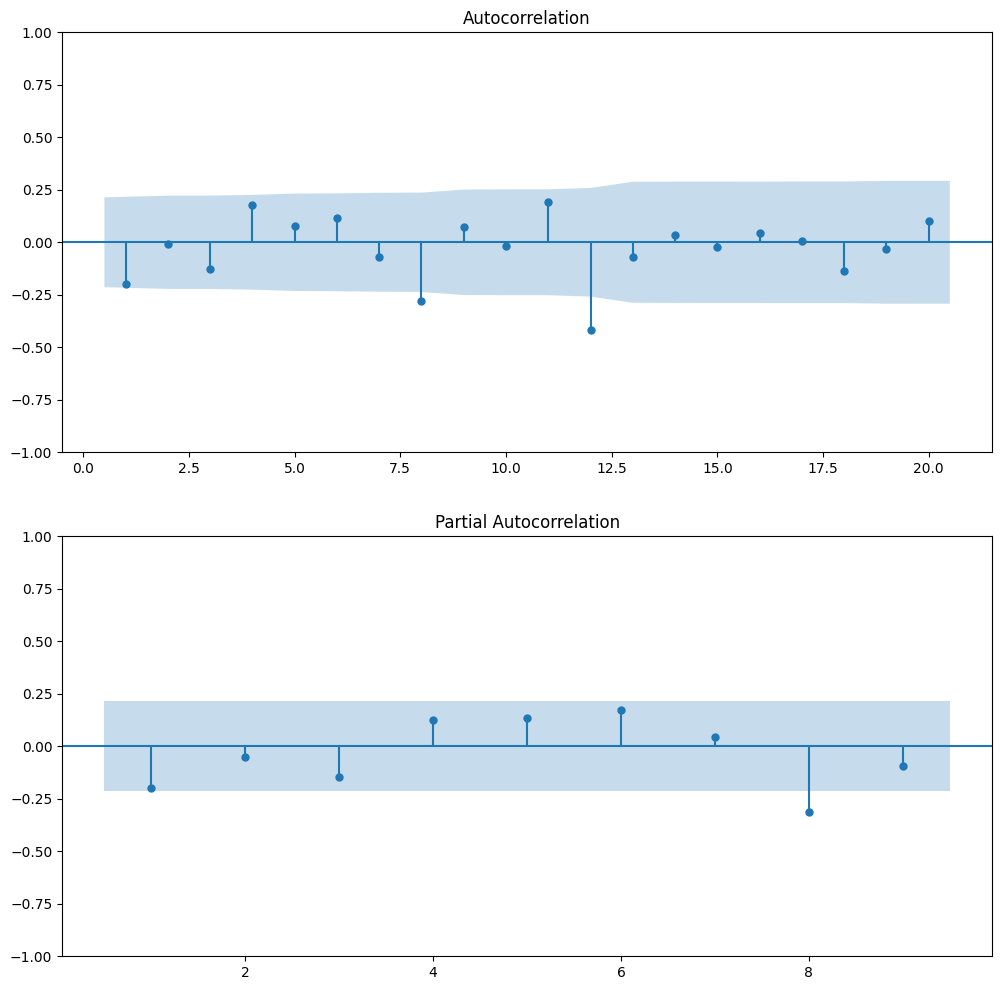

In [ ]:
# Fit ARIMA(1,1,1)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_bag_ts, order=(1,1,1), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

Fit the model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -686.125
Date:                          Sun, 22 Oct 2023   AIC                           1380.250
Time:                                  21:47:34   BIC                           1389.300
Sample:                                       0   HQIC                          1383.849
                                           - 84                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8053      0.351      2.297      0.022       0.118       1.492
ma.L1         -0.8665      0.314     -2.761      0.

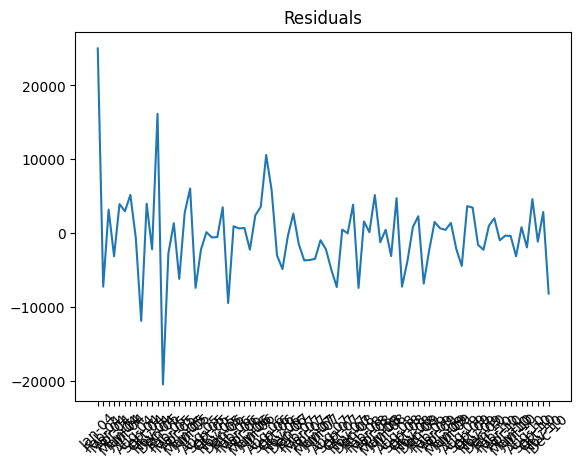

In [ ]:
# Fit ARIMA(1,1,0)x(1,1,1)[12] model to the data

#Best model for Baggage Complaints for American is ARIMA(3,1,0)x(0,1,1)[12]
fit_AR1 = ARIMA(united_bag_ts, order=(1,1,1), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


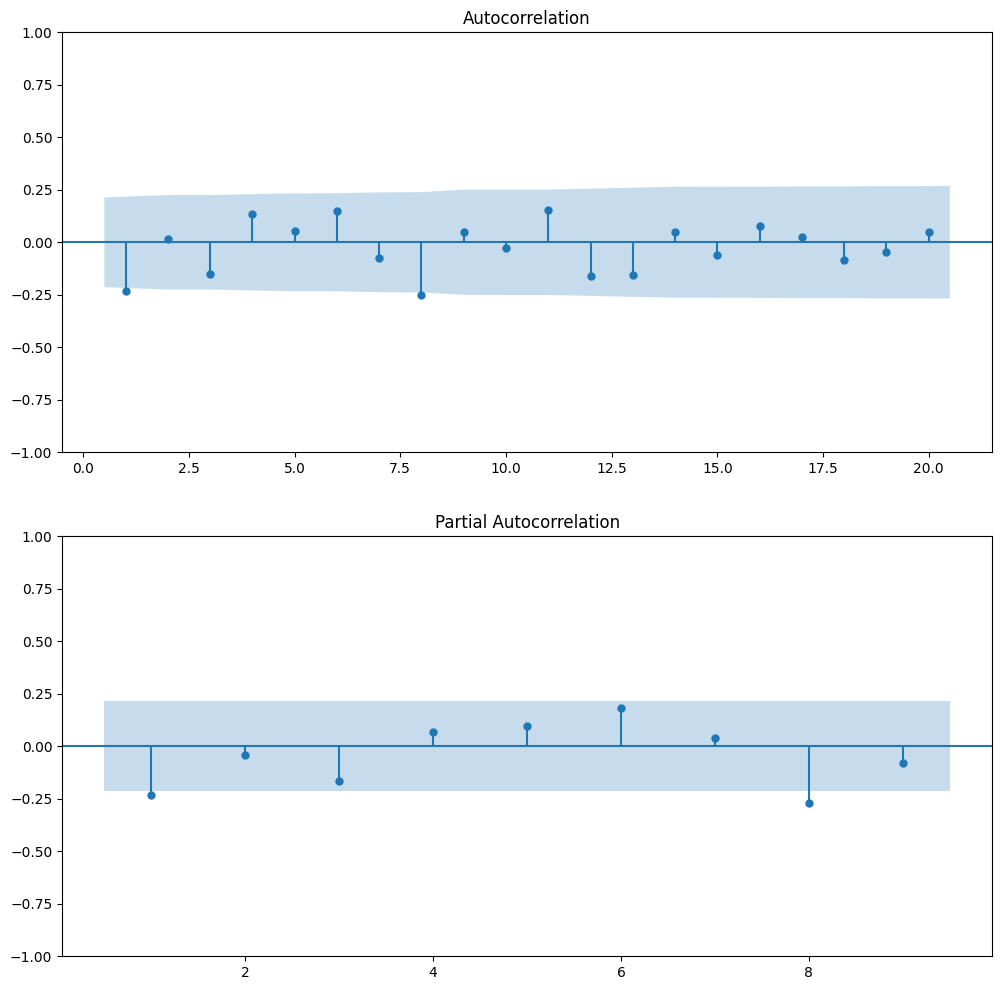

In [ ]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()


In [ ]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,17.257596,0.068855


In [ ]:
# convert predictions to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
Feb-04,23937.462220,15357.219574,32517.704865
Mar-04,16157.731581,7583.698837,24731.764325
Apr-04,18783.381667,10213.519496,27353.243839
May-04,15392.106639,6824.925466,23959.287811
Jun-04,18945.410217,10379.828056,27510.992377


In [ ]:
# add back actuals --
prediction_df = pd.concat([prediction_df,united_bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
Mar-04,16157.731581,7583.698837,24731.764325,19318
Apr-04,18783.381667,10213.519496,27353.243839,15638
May-04,15392.106639,6824.925466,23959.287811,19302
Jun-04,18945.410217,10379.828056,27510.992377,21892
Jul-04,21506.292630,12941.542213,30071.043047,26666


In [ ]:
# prediction_df.drop(columns=['Baggage'], inplace=True)

In [ ]:
# calc error
errors = prediction_df['Baggage'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Baggage'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 16.870%
RMSE = 4,873.624


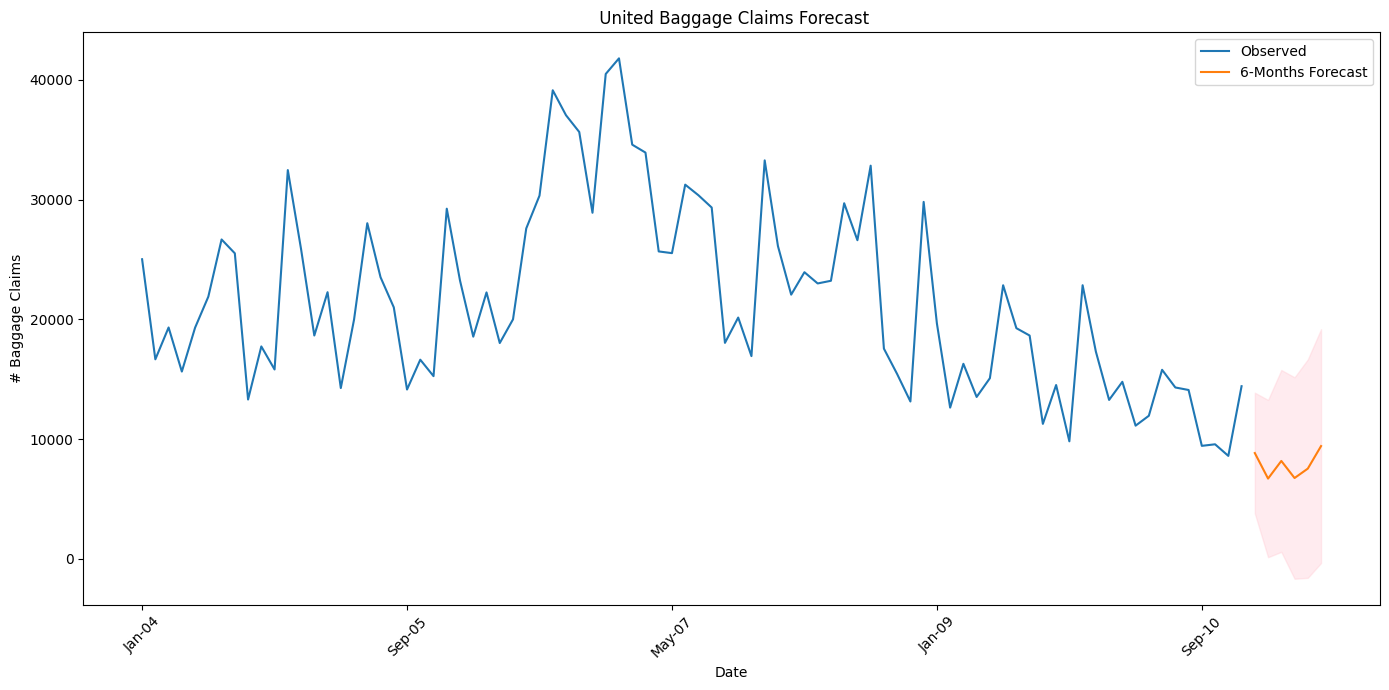

In [396]:

# Plot forecast
plt.figure(figsize=(14, 7))
united_bag_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title(" United Baggage Claims Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

### Cancelled Flights

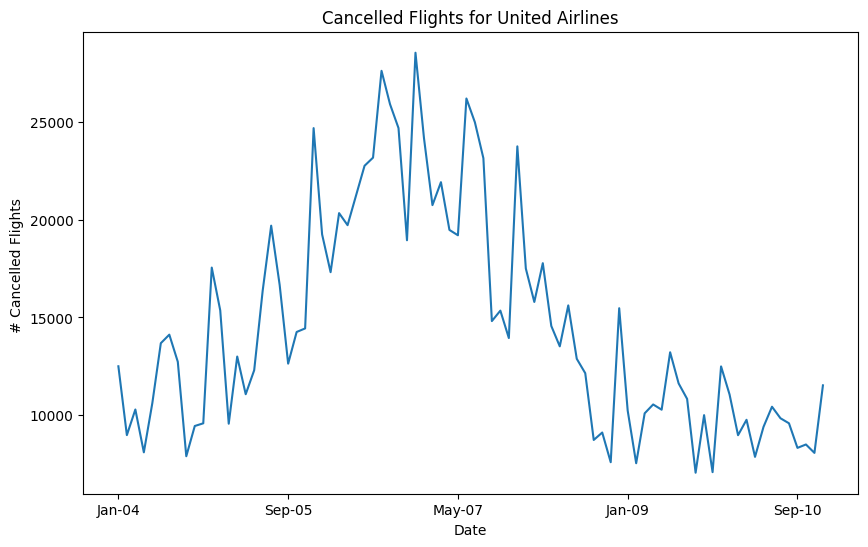

In [427]:
# United Airlines
# Convert date column to a date class variable
united_cancel_ts = pd.Series(united_dat['Cancelled'].values, index=united_dat['Date'])

# Create a monthly index for the series
united_cancel_ts.index.freq = 'MS'

#Plot the series
plt.figure(figsize=(10, 6))
american_bag_ts.plot()
plt.title("Cancelled Flights for United Airlines")
plt.xlabel("Date")
plt.ylabel("# Cancelled Flights ")
plt.show()

In [428]:
#execute the Ljung Box test on the Coffee series using 10 lags
united_cancel = united_dat[['Cancelled']]

sm.stats.acorr_ljungbox(united_cancel, lags=[10], return_df=True)

# Residuals are not white noise

,lb_stat,lb_pvalue
10,37.135304,0.000054


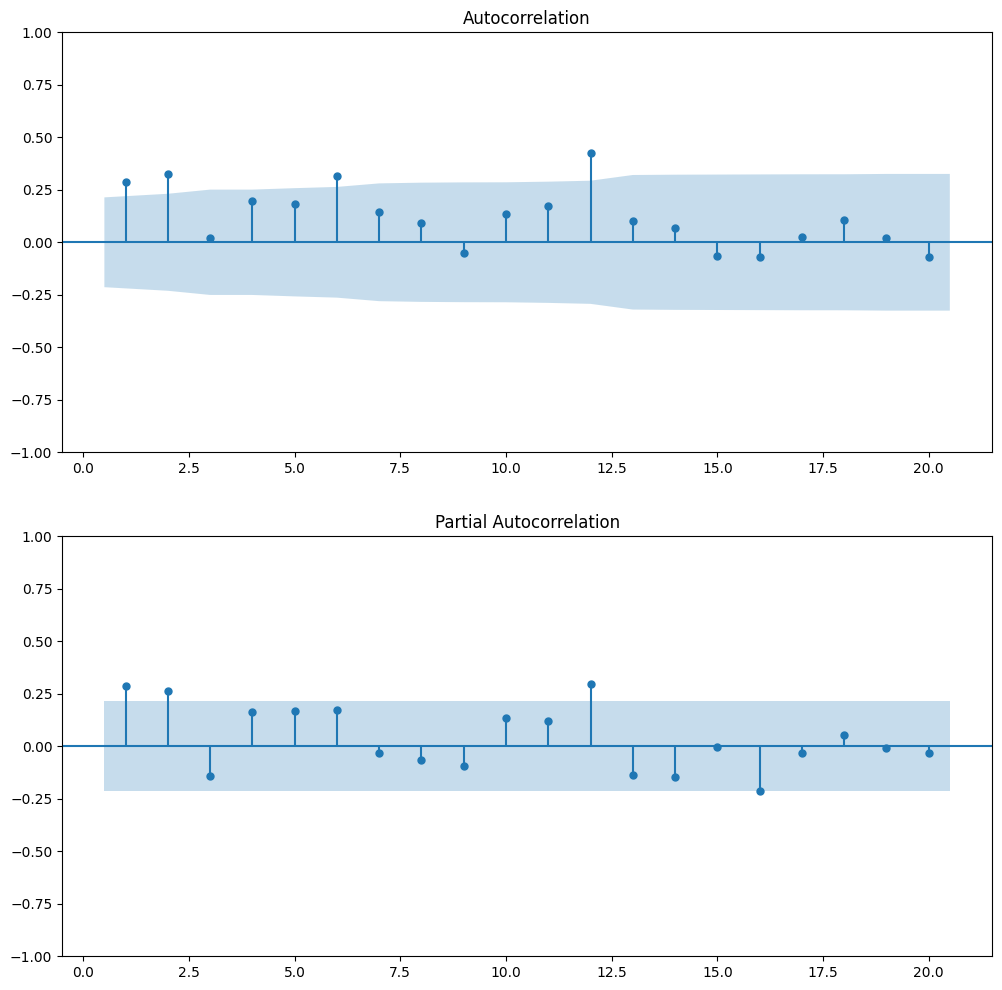

In [429]:
#Plot the ACF and PACF for the cancelled flight series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(united_cancel_ts, ax=ax1, zero=False)
plot_pacf(united_cancel_ts, ax=ax2, zero=False)
plt.show()

# Hard to tell what signature it is so just plug and chug

### For seasonal time series, the first step in the process is taking a seasonal difference. To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure. P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle). To take a seasonal difference set D=1.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


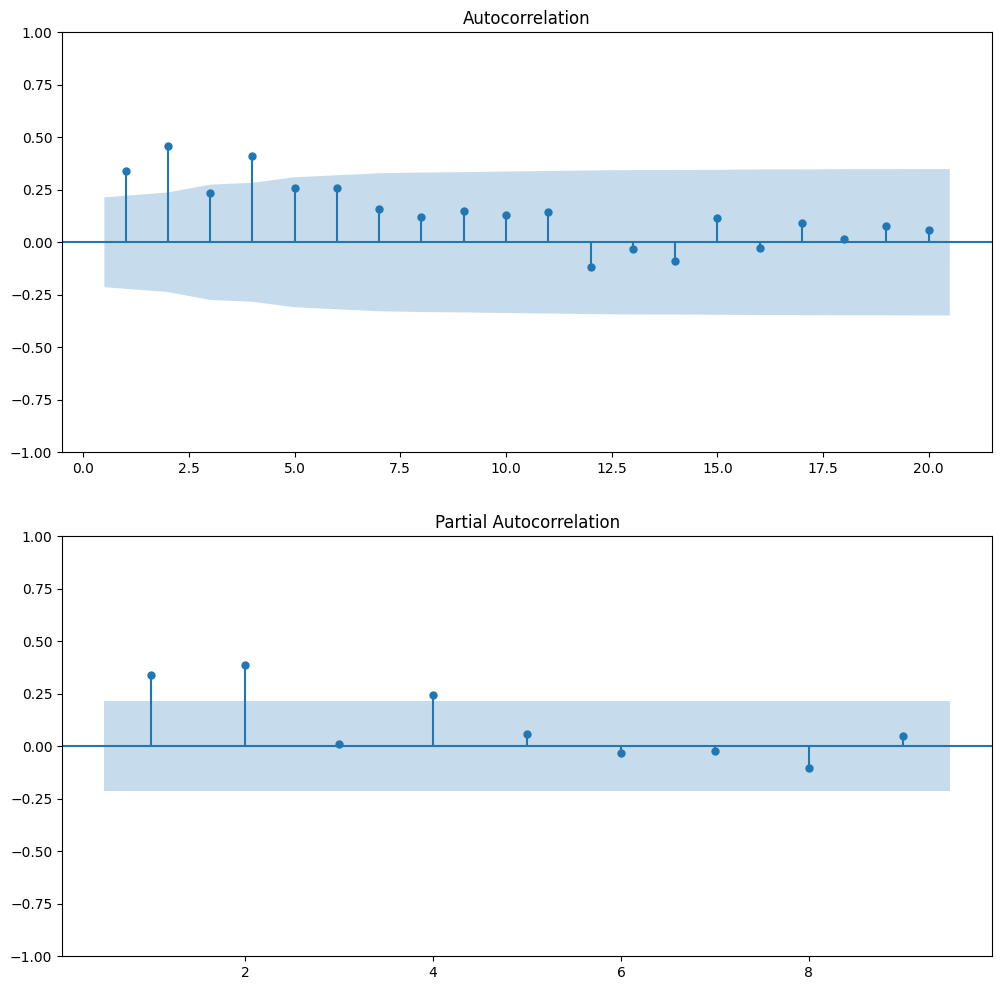

In [430]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_cancel_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


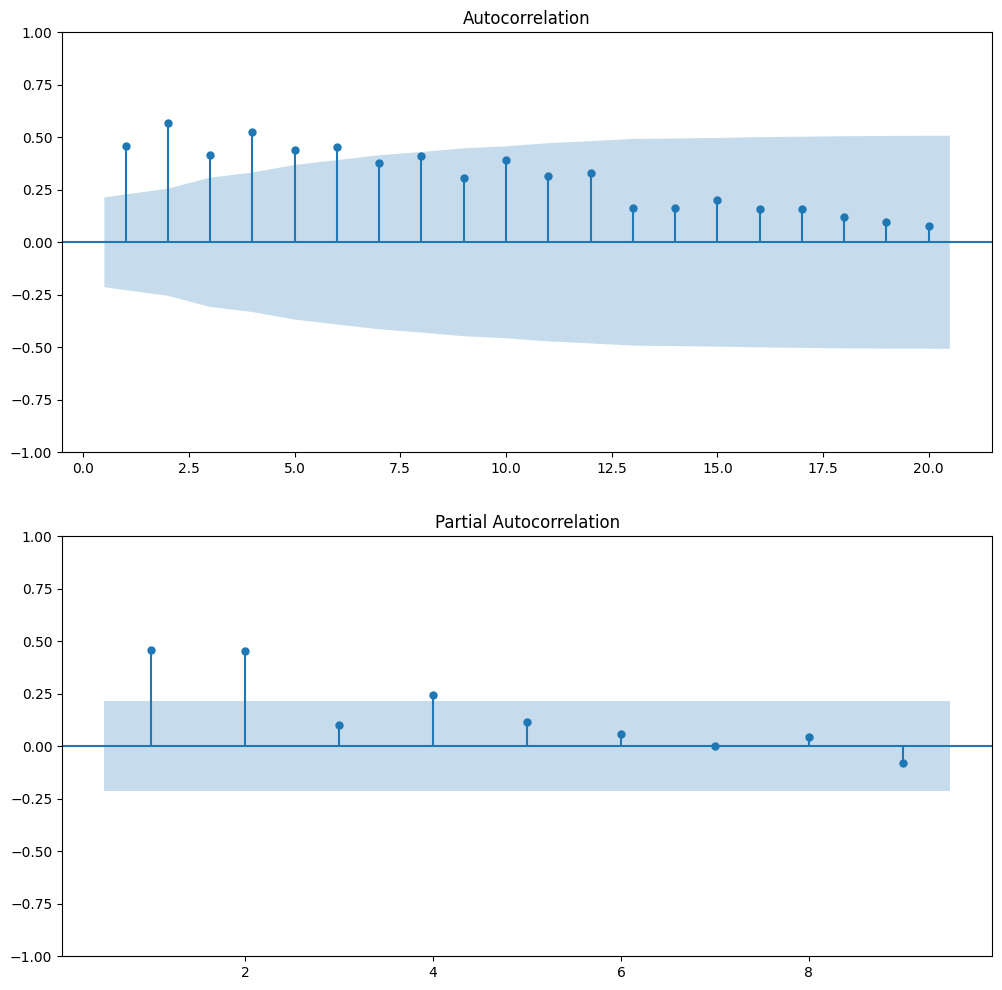

In [431]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 24-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_cancel_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 24)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


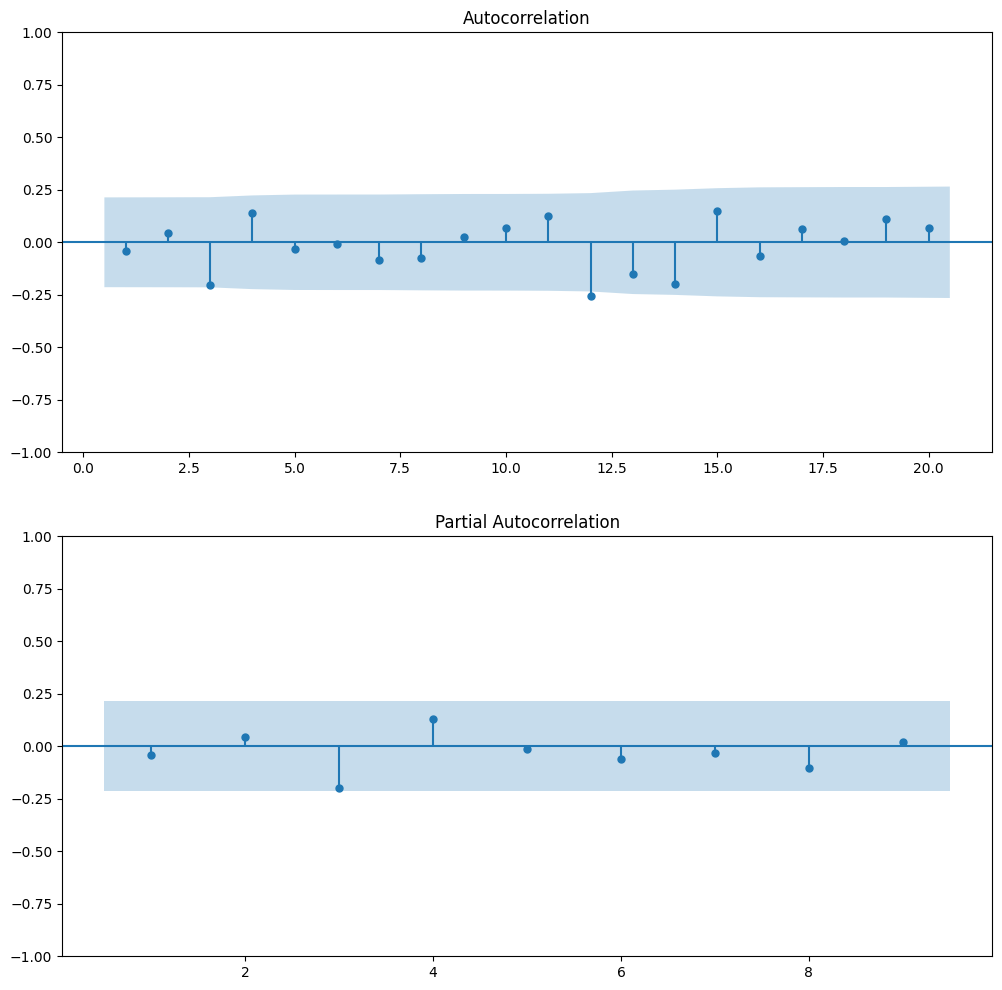

In [432]:
# Fit ARIMA(1,1,1)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_cancel_ts, order=(1,1,1), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()

Fit the ARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -519.743
Date:                          Mon, 23 Oct 2023   AIC                           1049.487
Time:                                  00:37:02   BIC                           1060.800
Sample:                                       0   HQIC                          1053.985
                                           - 84                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2109      0.127     -1.665      0.096      -0.459       0.037
ma.L1         -0.6693      0.110     -6.104      0.

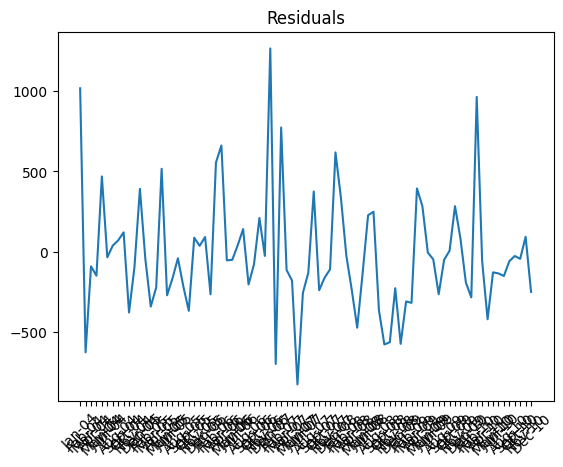

In [448]:
# Fit ARIMA(1,1,0)x(0,1,1)[12] model to the data

#Best model for Baggage Complaints for American is ARIMA(3,1,0)x(0,1,1)[12]
fit_AR1 = ARIMA(united_cancel_ts, order=(1,1,1), seasonal_order=(1, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


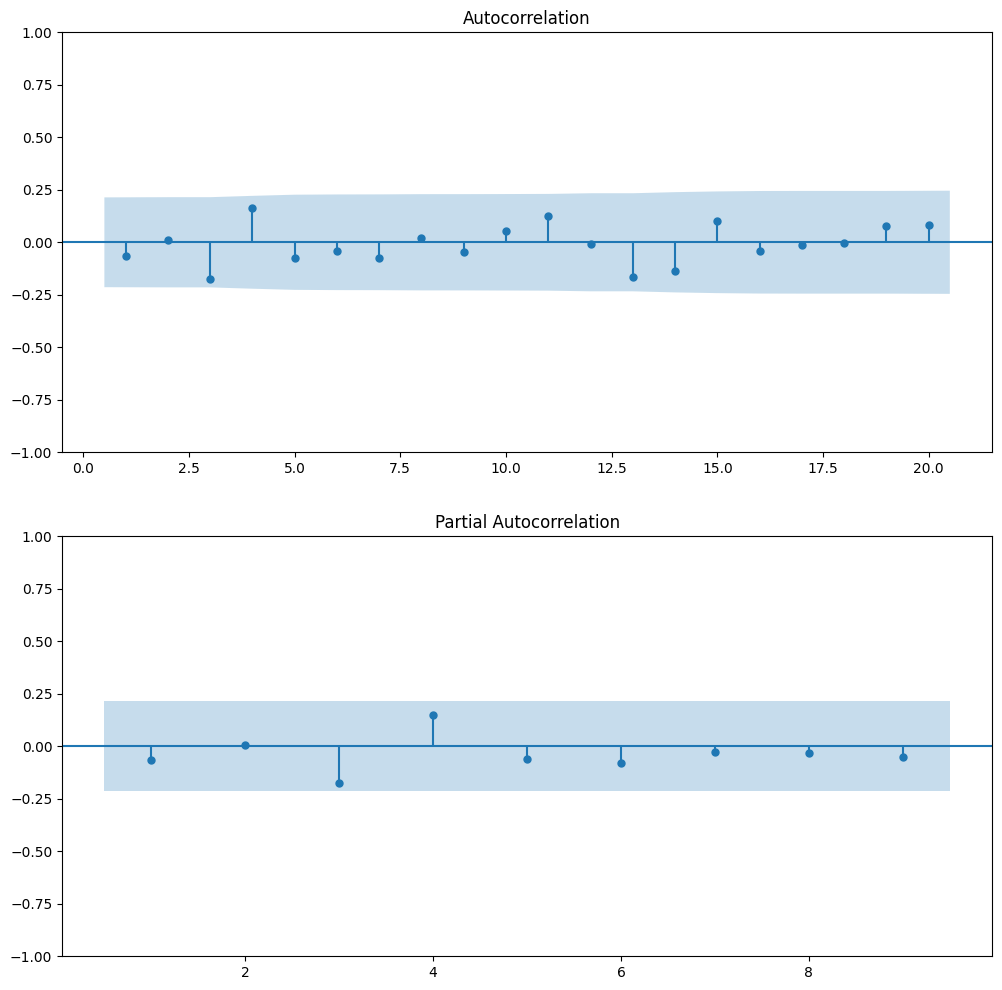

In [449]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()


In [450]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,7.246541,0.701983


In [474]:
# convert predictions to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
Feb-04,939.006100,-1287.842995,3165.855195
Mar-04,412.901827,-1804.899827,2630.703480
Apr-04,312.039143,-1905.709402,2529.787687
May-04,184.004140,-2033.744090,2401.752371
Jun-04,584.620746,-1633.127483,2802.368976


In [480]:
# add back actuals --
prediction_df = pd.concat([prediction_df,united_cancel_ts.to_frame(name='Cancelled Flights')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head(5)

,predicted_mean,lower_bound,upper_bound,Cancelled Flights
Date,,,,
Apr-04,312.039143,-1905.709402,2529.787687,162
May-04,184.004140,-2033.744090,2401.752371,652
Jun-04,584.620746,-1633.127483,2802.368976,549
Jul-04,567.973344,-1649.774884,2785.721573,605
Aug-04,596.098600,-1621.649623,2813.846822,666


In [481]:
# calc error
errors = prediction_df['Cancelled Flights'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Cancelled Flights'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 46.387%
RMSE = 351.575


In [479]:
prediction_df.drop(columns=['Cancelled Flights'], inplace = True)

In [482]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecasted_CPI,Lower_Bound,Upper_Bound
84,514.192257,-160.213343,1188.597857
85,753.438097,74.225368,1432.650826
86,278.952826,-430.598889,988.504541
87,138.327264,-593.499630,870.154158
88,146.663483,-608.108222,901.435188
89,315.882689,-460.881616,1092.646995


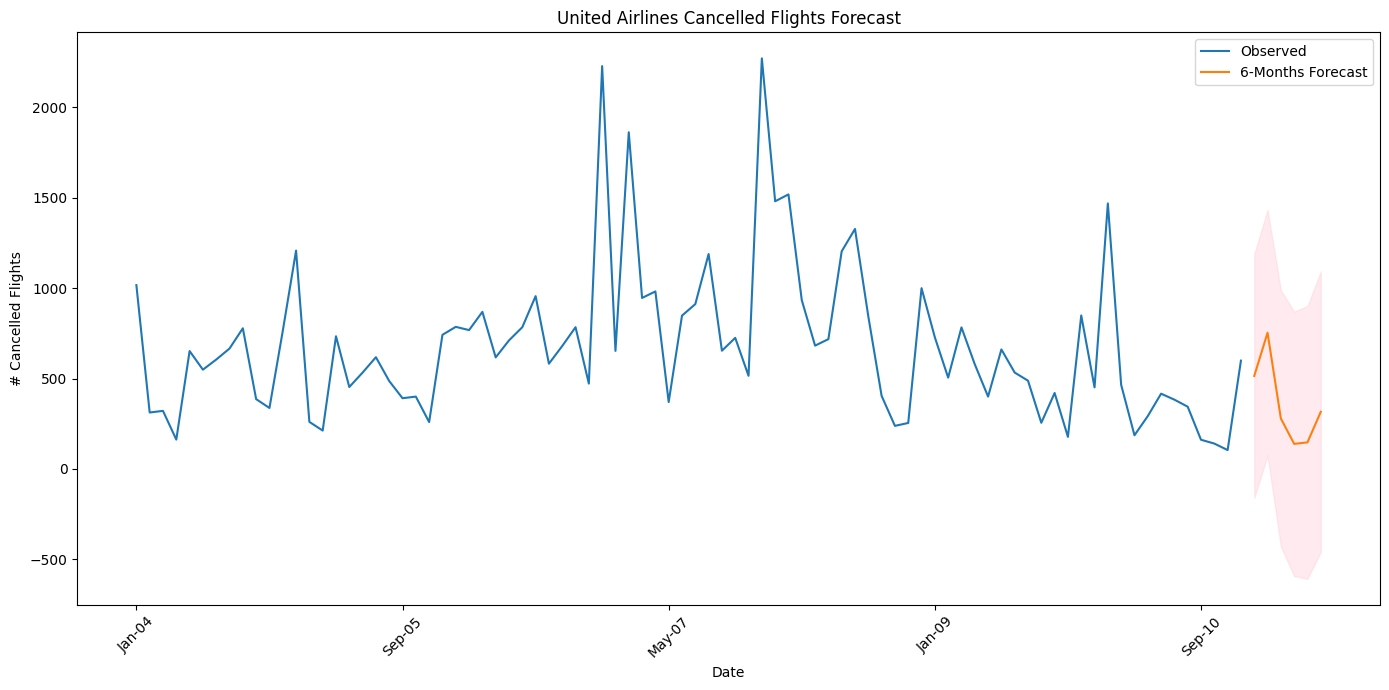

In [483]:

# Plot forecast
plt.figure(figsize=(14, 7))
united_cancel_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("United Airlines Cancelled Flights Forecast")
plt.xlabel("Date")
plt.ylabel("# Cancelled Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()